In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/Crop_recommendation.csv")
df.head(n=2)

df["label"].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Scaling X
for col in X.columns:
    col_max = X[col].abs().max()
    print(col_max)
    X[col] /= col_max

# Label Encoding y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

140
145
205
43.67549305
99.98187601
9.93509073
298.5601175


In [5]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, shuffle=True)

In [8]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(np.array(y).reshape(-1), dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
train = ClassificationDataset(X_train, y_train)
val = ClassificationDataset(X_val, y_val)
test = ClassificationDataset(X_test, y_test)

In [10]:
HIDDEN_NEURONS = 10
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.hidden_layer = nn.Linear(HIDDEN_NEURONS, HIDDEN_NEURONS)  
        self.output = nn.Linear(HIDDEN_NEURONS, len(np.unique(y)))  

        self.relu = nn.ReLU()  # ReLU for hidden layers
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.output(x)
        x = self.softmax(x)

        return x

In [11]:
model = Model().to(device)
from torchsummary import summary

summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              80
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 22]             242
           Softmax-6                   [-1, 22]               0
Total params: 432
Trainable params: 432
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [12]:
BATCH_SIZE = 32
EPOCHS = 100
HIDDEN_NEURONS = 10
LR = 1e-3

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [16]:
def train_model(model, train_dataset, val_dataset, criterion, epochs_config):
    total_loss_train_plot = []
    total_loss_validation_plot = []
    total_acc_train_plot = []
    total_acc_validation_plot = []
    
    for epoch, config in enumerate(epochs_config):
        for e in range(EPOCHS):
            batch_size = config.get("batch_size", 32)
            learning_rate = config.get("learning_rate", 0.001)
            optimizer_type = config.get("optimizer", "adam").lower()
            
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            if optimizer_type == "adam":
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            elif optimizer_type == "sgd":
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
            else:
                raise ValueError(f"Unsupported optimizer: {optimizer_type}")
            
            total_acc_train = 0
            total_loss_train = 0
            total_acc_val = 0
            total_loss_val = 0
            
            ## Training Loop
            for data in train_dataloader:
                inputs, labels = data
                labels = labels.long()
                prediction = model(inputs)
                batch_loss = criterion(prediction, labels)
                total_loss_train += batch_loss.item()
                
                acc = (prediction.argmax(dim=1) == labels).sum().item()
                total_acc_train += acc
                
                batch_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            ## Validation Loop
            with torch.no_grad():
                for data in val_dataloader:
                    inputs, labels = data
                    labels = labels.long()
                    prediction = model(inputs)
                    batch_loss = criterion(prediction, labels)
                    total_loss_val += batch_loss.item()
                    
                    acc = (prediction.argmax(dim=1) == labels).sum().item()
                    total_acc_val += acc
            
            total_loss_train_plot.append(round(total_loss_train / len(train_dataloader), 4))
            total_loss_validation_plot.append(round(total_loss_val / len(val_dataloader), 4))
            total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))
            total_acc_validation_plot.append(round(total_acc_val / len(val_dataset) * 100, 4))
            
            print(f"Epoch {epoch + 1}: Batch Size: {batch_size}, LR: {learning_rate}, Optimizer: {optimizer_type}")
            print(f"Train Loss: {total_loss_train / len(train_dataloader):.4f}, Train Accuracy: {total_acc_train / len(train_dataset) * 100:.4f}%")
            print(f"Validation Loss: {total_loss_val / len(val_dataloader):.4f}, Validation Accuracy: {total_acc_val / len(val_dataset) * 100:.4f}%")
            print("=" * 50)
        
        return {
            "train_loss": total_loss_train_plot,
            "val_loss": total_loss_validation_plot,
            "train_acc": total_acc_train_plot,
            "val_acc": total_acc_validation_plot
        }

# Example usage:
epochs_config = [
    {"batch_size": 32, "learning_rate": 0.001, "optimizer": "adam"},
    {"batch_size": 64, "learning_rate": 0.0005, "optimizer": "sgd"},
    {"batch_size": 128, "learning_rate": 0.0001, "optimizer": "adam"}
]


train_model(model, train, val, criterion, epochs_config)

Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0908, Train Accuracy: 4.3506%
Validation Loss: 3.0909, Validation Accuracy: 4.8485%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0905, Train Accuracy: 4.3506%
Validation Loss: 3.0906, Validation Accuracy: 4.8485%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0901, Train Accuracy: 4.3506%
Validation Loss: 3.0902, Validation Accuracy: 4.8485%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0898, Train Accuracy: 4.0260%
Validation Loss: 3.0895, Validation Accuracy: 5.1515%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0887, Train Accuracy: 4.6104%
Validation Loss: 3.0888, Validation Accuracy: 6.3636%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0880, Train Accuracy: 7.7922%
Validation Loss: 3.0877, Validation Accuracy: 7.8788%
Epoch 1: Batch Size: 32, LR: 0.001, Optimizer: adam
Train Loss: 3.0866, Train Accuracy: 9.2857%
Vali

{'train_loss': [3.0908,
  3.0905,
  3.0901,
  3.0898,
  3.0887,
  3.088,
  3.0866,
  3.0848,
  3.0825,
  3.0774,
  3.0712,
  3.064,
  3.0571,
  3.0517,
  3.0472,
  3.0443,
  3.0413,
  3.0327,
  3.0278,
  3.0303,
  3.0169,
  3.0225,
  3.0134,
  3.0095,
  3.0059,
  3.0022,
  2.9997,
  2.995,
  2.988,
  2.9862,
  2.9805,
  2.9751,
  2.9711,
  2.9682,
  2.96,
  2.9595,
  2.9475,
  2.949,
  2.9408,
  2.9379,
  2.9328,
  2.928,
  2.9176,
  2.9119,
  2.9028,
  2.9,
  2.8969,
  2.8915,
  2.8831,
  2.8734,
  2.8757,
  2.869,
  2.8616,
  2.8583,
  2.8529,
  2.8391,
  2.8401,
  2.837,
  2.8325,
  2.8214,
  2.8194,
  2.8162,
  2.81,
  2.8046,
  2.806,
  2.8035,
  2.7907,
  2.7938,
  2.7841,
  2.7851,
  2.7828,
  2.7776,
  2.7697,
  2.7722,
  2.7728,
  2.7618,
  2.7601,
  2.7514,
  2.7564,
  2.755,
  2.7469,
  2.7414,
  2.7426,
  2.7376,
  2.7397,
  2.7355,
  2.7243,
  2.7233,
  2.7216,
  2.7218,
  2.7125,
  2.7125,
  2.708,
  2.7107,
  2.7065,
  2.6998,
  2.6993,
  2.6954,
  2.6917,
  2.6875],
 'v

NameError: name 'total_loss_train_plot' is not defined

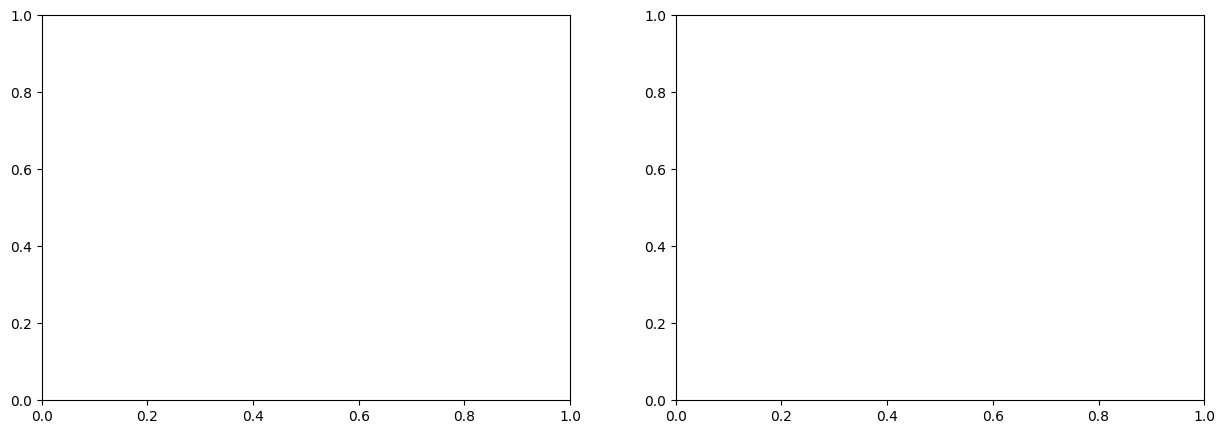

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    labels = labels.long()
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")
     

Accuracy Score is: 86.97%


In [ ]:
torch.save(model.state_dict(), "./models/tabular_sowing_classification.pt")

In [ ]:
model = model.load_state_dict(torch.load("./models/tabular_sowing_classification.pt"))